In [1]:
# Import necessary libraries
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Load preprocessed data
processed_data_path = '../data/processed/etth1_processed.csv'  # Adjust path if needed
df = pd.read_csv(processed_data_path, index_col='date', parse_dates=True)

In [3]:

# Ensure the data is properly scaled and interpolated
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

In [4]:
# Define the time series dataset for the Transformer model
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window=48):
        self.window = window
        self.data = torch.tensor(series.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data) - self.window

    def __getitem__(self, idx):
        return self.data[idx:idx+self.window], self.data[idx+self.window]


In [5]:
# Prepare the data (e.g., using 'OT' column as the target)
target_series = scaled_df['OT']  # You can adjust this column name based on your data
train_dataset = TimeSeriesDataset(target_series, window=48)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
# Define the Transformer model (You can replace this with actual Informer/PatchTST model)
class TransformerModel(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super(TransformerModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)  # Use LSTM as a placeholder
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(-1))  # Adding the required dimension for LSTM
        return self.fc(out[:, -1, :])  # Output the last hidden state

In [7]:

# Initialize model, optimizer, and loss function
model = TransformerModel()  # Replace with actual Informer/PatchTST model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

In [9]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        # Forward pass
        pred = model(x)
        loss = loss_fn(pred, y.unsqueeze(-1))  # Ensure y has correct shape
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), '../models/transformer_model.pth')

Epoch 1/10, Loss: 0.0006
Epoch 2/10, Loss: 0.0006
Epoch 3/10, Loss: 0.0006
Epoch 4/10, Loss: 0.0005
Epoch 5/10, Loss: 0.0005
Epoch 6/10, Loss: 0.0005
Epoch 7/10, Loss: 0.0005
Epoch 8/10, Loss: 0.0005
Epoch 9/10, Loss: 0.0005
Epoch 10/10, Loss: 0.0004


In [11]:
# Evaluation
model.eval()
predictions = []
true_values = []
with torch.no_grad():
    for x, y in train_loader:
        pred = model(x)
        predictions.append(pred.numpy())
        true_values.append(y.numpy())

predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# Inverse transform predictions and true values
# Add dummy columns to match the scaler's expected input shape
dummy_shape = (predictions.shape[0], scaled_df.shape[1])  # Match the number of columns in the original data
predictions_full = np.zeros(dummy_shape)
true_values_full = np.zeros(dummy_shape)

# Fill the relevant column (e.g., 'OT') with predictions and true values
predictions_full[:, -1] = predictions.flatten()
true_values_full[:, -1] = true_values.flatten()

# Apply inverse transform
predictions = scaler.inverse_transform(predictions_full)[:, -1]  # Extract the 'OT' column
true_values = scaler.inverse_transform(true_values_full)[:, -1]  # Extract the 'OT' column

MSE: 0.0005, MAE: 0.0169


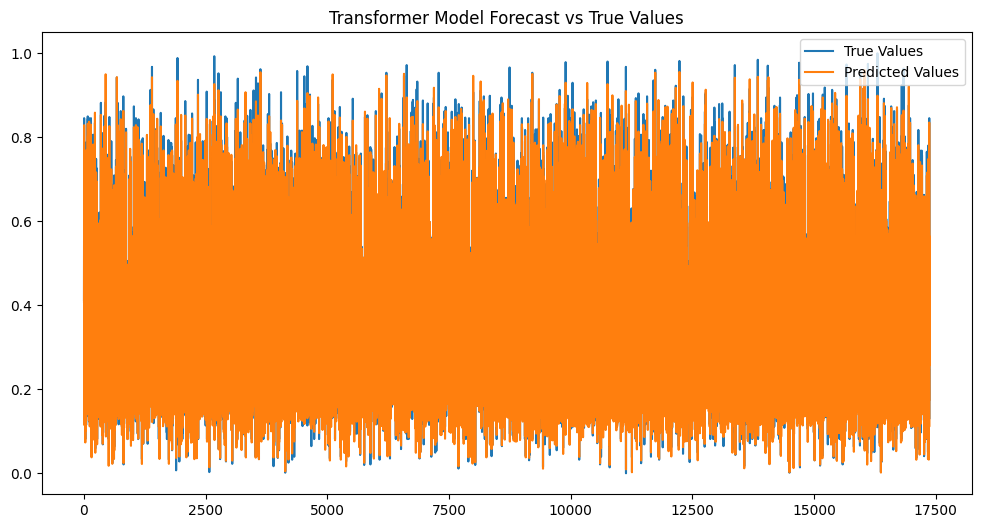

Results saved to transformer_predictions.csv


In [12]:

# Calculate metrics
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# Plot the results for comparison
plt.figure(figsize=(12, 6))
plt.plot(true_values, label="True Values")
plt.plot(predictions, label="Predicted Values")
plt.legend()
plt.title("Transformer Model Forecast vs True Values")
plt.show()

# Save the results for comparison
results = pd.DataFrame({
    "True Values": true_values.flatten(),
    "Predictions": predictions.flatten()
})

results.to_csv('transformer_predictions.csv', index=False)
print("Results saved to transformer_predictions.csv")
